# Gerando Imagens de Olhos com VAE e GAN

- VAE (Variational Autoencoder)
- GAN (Generative Adversarial Network)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Ver se tem GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

# pasta para salvar resultados
if not os.path.exists("/content/resultados_olhos_150ep"):
    os.mkdir("/content/resultados_olhos_150ep")

Usando: cpu


In [2]:
# parâmetros
pasta_olhos = "/kaggle/input/eye-detection-dataset/Dataset/train/images"

tamanho_img = 64  # (64x64)
tamanho_batch = 32  # imagens por vez
epocas = 150  
dim_latente = 100  # vetor de ruído
mostrar_a_cada = 25

Carregando imagens de olhos de: /kaggle/input/eye-detection-dataset/Dataset/train/images
Total de imagens encontradas: 1385
Total de imagens de olhos: 1385
Número de lotes (batches): 44


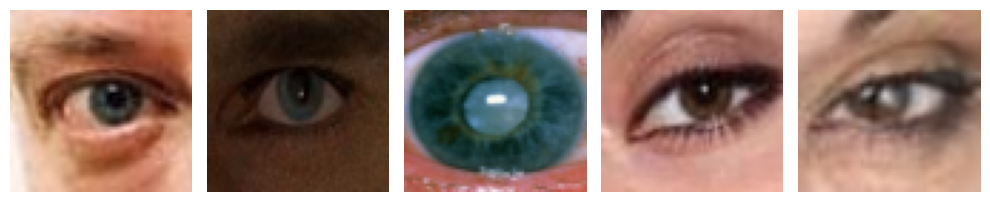

In [3]:
class DatasetOlhos(Dataset):
    def __init__(self, pasta):
        self.pasta = pasta
        # Pegar só arquivos de imagem
        self.lista_imgs = [f for f in os.listdir(pasta) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        print(f"Total de imagens encontradas: {len(self.lista_imgs)}")
        
        # Transformações para deixar as imagens do mesmo tamanho e normalizadas
        self.transformacao = transforms.Compose([
            transforms.Resize((tamanho_img, tamanho_img)),
            transforms.ToTensor(), # Converte pra tensor (números pro PyTorch)
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normaliza pra ficar entre -1 e 1
        ])
    
    def __len__(self):
        # Quantas imagens tem
        return len(self.lista_imgs)
    
    def __getitem__(self, idx):
        # Pega uma imagem pelo índice
        caminho_img = os.path.join(self.pasta, self.lista_imgs[idx])
        try:
            # Abre a imagem e converte pra RGB (3 canais de cor)
            img = Image.open(caminho_img).convert("RGB")
            # Aplica as transformações
            return self.transformacao(img)
        except Exception as e:
            # Se der erro ao abrir, avisa e retorna uma imagem preta
            print(f"Erro ao carregar imagem {caminho_img}: {e}")
            return torch.zeros(3, tamanho_img, tamanho_img)

# Carregar o dataset
print(f"Carregando imagens de olhos de: {pasta_olhos}")
dataset = DatasetOlhos(pasta_olhos)
print(f"Total de imagens de olhos: {len(dataset)}")

# Criar o DataLoader (pra carregar as imagens em lotes)
dataloader = DataLoader(dataset, batch_size=tamanho_batch, shuffle=True)

print(f"Número de lotes (batches): {len(dataloader)}")

# Mostrar algumas imagens de exemplo pra ver se carregou certo
plt.figure(figsize=(10, 5))
# Pega um lote de imagens
sample_batch = next(iter(dataloader))
for i in range(min(5, tamanho_batch)): # Mostra até 5 imagens
    img = sample_batch[i]
    img = (img + 1) / 2.0  # Desnormalizar (voltar pra 0 a 1)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.permute(1, 2, 0))  # Mudar ordem dos eixos pra (Altura, Largura, Cor)
    plt.axis("off") # Tira os eixos x e y
plt.tight_layout()
plt.show()

## Parte 1: VAE (Variational Autoencoder)

- **Encoder**: Comprime a imagem num código pequeno (vetor latente).
- **Decoder**: Tenta recriar a imagem a partir desse código.

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # --- Encoder ---
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1) # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1) # 16x16 -> 8x8
        self.fc_mu = nn.Linear(128 * 8 * 8, dim_latente)
        self.fc_logvar = nn.Linear(128 * 8 * 8, dim_latente)
        
        # --- Decoder ---
        self.fc_decode = nn.Linear(dim_latente, 128 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1) # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1) # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(32, 3, 4, 2, 1) # 32x32 -> 64x64
    
    def encode(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = h.view(-1, 128 * 8 * 8) 
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc_decode(z))
        h = h.view(-1, 128, 8, 8) 
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        return torch.tanh(self.deconv3(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar) 
        return self.decode(z), mu, logvar

vae = VAE().to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=0.0002)

def calcular_perda_vae(recon_x, x, mu, logvar):
    erro_recon = F.mse_loss(recon_x, x, reduction="sum")
    erro_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return erro_recon + erro_kl

--- Iniciando Treinamento do VAE (150 Épocas) ---
  Época 1/150 - Lote 0/44, Perda por imagem: 2881.9543
-> Fim da Época 1/150 - Perda média: 2430.9835
  Época 2/150 - Lote 0/44, Perda por imagem: 1947.8658
-> Fim da Época 2/150 - Perda média: 1960.3090
  Época 3/150 - Lote 0/44, Perda por imagem: 1815.1658
-> Fim da Época 3/150 - Perda média: 1492.9627
  Época 4/150 - Lote 0/44, Perda por imagem: 1226.1726
-> Fim da Época 4/150 - Perda média: 976.5997
  Época 5/150 - Lote 0/44, Perda por imagem: 833.3999
-> Fim da Época 5/150 - Perda média: 815.6778
  Época 6/150 - Lote 0/44, Perda por imagem: 811.9636
-> Fim da Época 6/150 - Perda média: 729.6685
  Época 7/150 - Lote 0/44, Perda por imagem: 770.3157
-> Fim da Época 7/150 - Perda média: 660.3577
  Época 8/150 - Lote 0/44, Perda por imagem: 562.2718
-> Fim da Época 8/150 - Perda média: 606.1974
  Época 9/150 - Lote 0/44, Perda por imagem: 649.4292
-> Fim da Época 9/150 - Perda média: 567.3068
  Época 10/150 - Lote 0/44, Perda por image

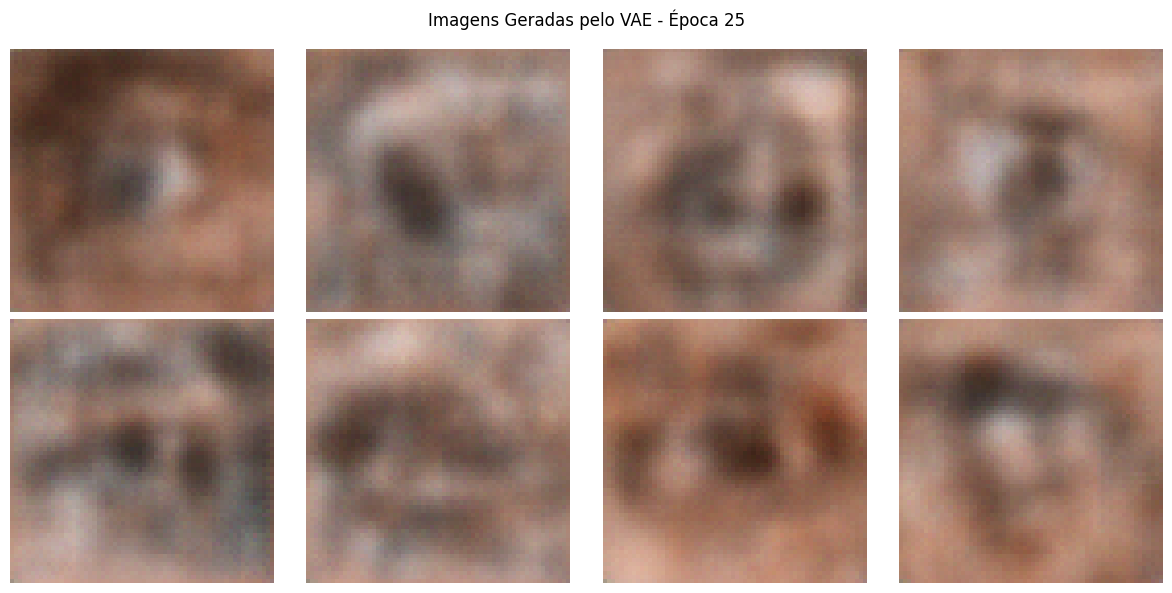

  Época 26/150 - Lote 0/44, Perda por imagem: 360.6778
-> Fim da Época 26/150 - Perda média: 389.9663
  Época 27/150 - Lote 0/44, Perda por imagem: 361.5105
-> Fim da Época 27/150 - Perda média: 384.3621
  Época 28/150 - Lote 0/44, Perda por imagem: 393.2441
-> Fim da Época 28/150 - Perda média: 383.9425
  Época 29/150 - Lote 0/44, Perda por imagem: 354.2359
-> Fim da Época 29/150 - Perda média: 377.8868
  Época 30/150 - Lote 0/44, Perda por imagem: 377.9809
-> Fim da Época 30/150 - Perda média: 373.2452
  Época 31/150 - Lote 0/44, Perda por imagem: 358.0490
-> Fim da Época 31/150 - Perda média: 369.4633
  Época 32/150 - Lote 0/44, Perda por imagem: 385.4023
-> Fim da Época 32/150 - Perda média: 367.1740
  Época 33/150 - Lote 0/44, Perda por imagem: 347.7692
-> Fim da Época 33/150 - Perda média: 364.4993
  Época 34/150 - Lote 0/44, Perda por imagem: 370.2961
-> Fim da Época 34/150 - Perda média: 361.1723
  Época 35/150 - Lote 0/44, Perda por imagem: 326.0424
-> Fim da Época 35/150 - Pe

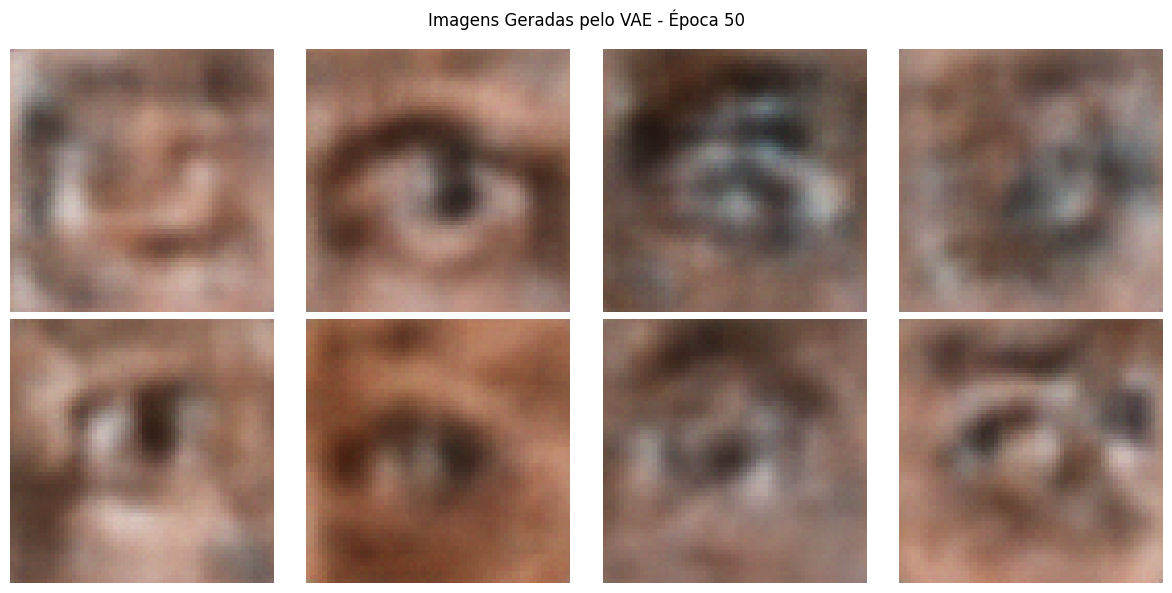

  Época 51/150 - Lote 0/44, Perda por imagem: 334.4361
-> Fim da Época 51/150 - Perda média: 322.8486
  Época 52/150 - Lote 0/44, Perda por imagem: 312.7068
-> Fim da Época 52/150 - Perda média: 321.9232
  Época 53/150 - Lote 0/44, Perda por imagem: 384.8974
-> Fim da Época 53/150 - Perda média: 322.0040
  Época 54/150 - Lote 0/44, Perda por imagem: 302.6538
-> Fim da Época 54/150 - Perda média: 318.1755
  Época 55/150 - Lote 0/44, Perda por imagem: 285.4473
-> Fim da Época 55/150 - Perda média: 314.9714
  Época 56/150 - Lote 0/44, Perda por imagem: 299.1237
-> Fim da Época 56/150 - Perda média: 313.9823
  Época 57/150 - Lote 0/44, Perda por imagem: 307.6703
-> Fim da Época 57/150 - Perda média: 313.0281
  Época 58/150 - Lote 0/44, Perda por imagem: 343.4363
-> Fim da Época 58/150 - Perda média: 312.2431
  Época 59/150 - Lote 0/44, Perda por imagem: 348.6964
-> Fim da Época 59/150 - Perda média: 309.9504
  Época 60/150 - Lote 0/44, Perda por imagem: 303.0443
-> Fim da Época 60/150 - Pe

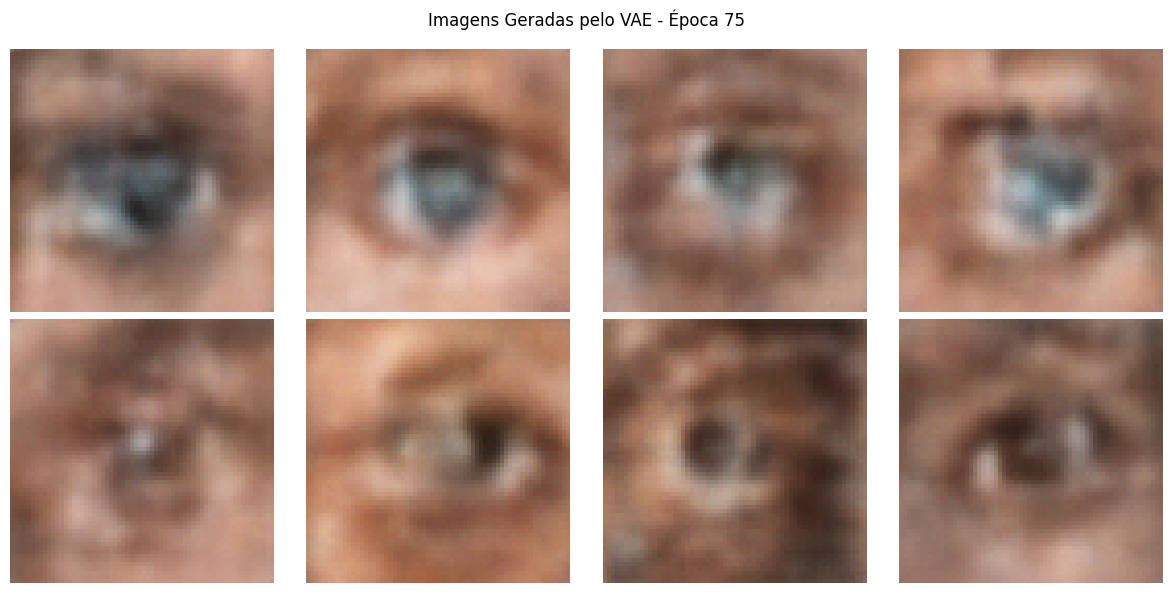

  Época 76/150 - Lote 0/44, Perda por imagem: 297.7173
-> Fim da Época 76/150 - Perda média: 288.4861
  Época 77/150 - Lote 0/44, Perda por imagem: 277.6386
-> Fim da Época 77/150 - Perda média: 287.9512
  Época 78/150 - Lote 0/44, Perda por imagem: 274.5888
-> Fim da Época 78/150 - Perda média: 286.6278
  Época 79/150 - Lote 0/44, Perda por imagem: 305.6236
-> Fim da Época 79/150 - Perda média: 286.6644
  Época 80/150 - Lote 0/44, Perda por imagem: 272.6676
-> Fim da Época 80/150 - Perda média: 287.9120
  Época 81/150 - Lote 0/44, Perda por imagem: 286.5515
-> Fim da Época 81/150 - Perda média: 285.2628
  Época 82/150 - Lote 0/44, Perda por imagem: 267.3049
-> Fim da Época 82/150 - Perda média: 283.6398
  Época 83/150 - Lote 0/44, Perda por imagem: 267.7839
-> Fim da Época 83/150 - Perda média: 282.6547
  Época 84/150 - Lote 0/44, Perda por imagem: 303.7482
-> Fim da Época 84/150 - Perda média: 281.9634
  Época 85/150 - Lote 0/44, Perda por imagem: 266.1031
-> Fim da Época 85/150 - Pe

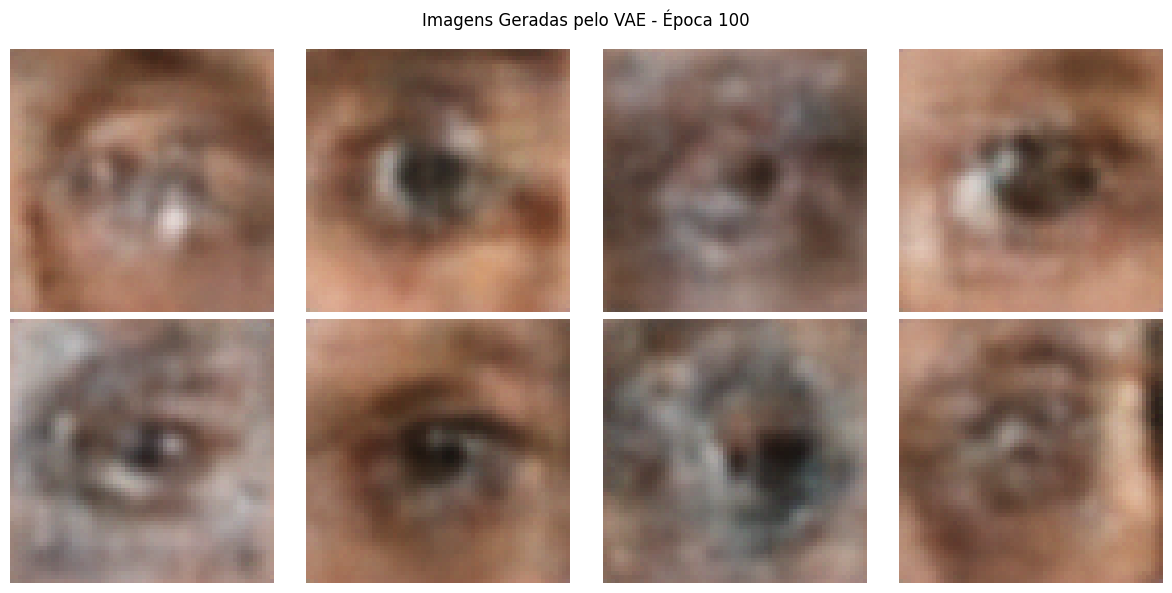

  Época 101/150 - Lote 0/44, Perda por imagem: 248.7484
-> Fim da Época 101/150 - Perda média: 267.2550
  Época 102/150 - Lote 0/44, Perda por imagem: 257.1806
-> Fim da Época 102/150 - Perda média: 266.7800
  Época 103/150 - Lote 0/44, Perda por imagem: 281.8234
-> Fim da Época 103/150 - Perda média: 266.1090
  Época 104/150 - Lote 0/44, Perda por imagem: 272.9987
-> Fim da Época 104/150 - Perda média: 267.8445
  Época 105/150 - Lote 0/44, Perda por imagem: 259.5483
-> Fim da Época 105/150 - Perda média: 267.4296
  Época 106/150 - Lote 0/44, Perda por imagem: 272.3406
-> Fim da Época 106/150 - Perda média: 268.9208
  Época 107/150 - Lote 0/44, Perda por imagem: 254.0190
-> Fim da Época 107/150 - Perda média: 263.6470
  Época 108/150 - Lote 0/44, Perda por imagem: 265.6116
-> Fim da Época 108/150 - Perda média: 263.6045
  Época 109/150 - Lote 0/44, Perda por imagem: 254.4967
-> Fim da Época 109/150 - Perda média: 262.3933
  Época 110/150 - Lote 0/44, Perda por imagem: 269.6097
-> Fim d

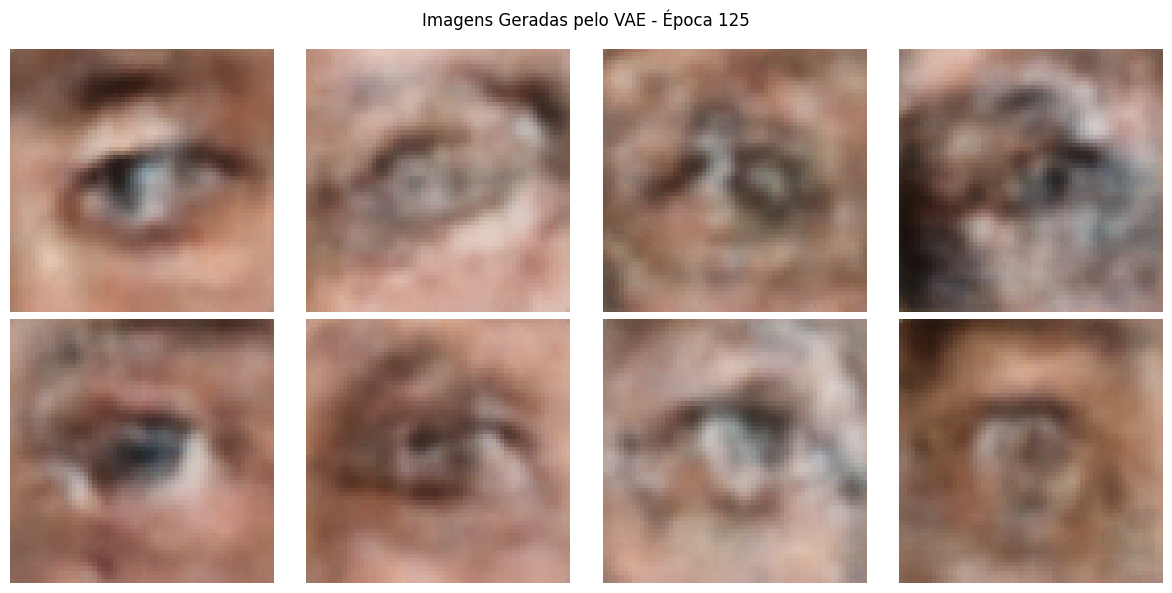

  Época 126/150 - Lote 0/44, Perda por imagem: 249.5436
-> Fim da Época 126/150 - Perda média: 252.1981
  Época 127/150 - Lote 0/44, Perda por imagem: 247.8064
-> Fim da Época 127/150 - Perda média: 250.9360
  Época 128/150 - Lote 0/44, Perda por imagem: 272.3554
-> Fim da Época 128/150 - Perda média: 251.4600
  Época 129/150 - Lote 0/44, Perda por imagem: 260.8566
-> Fim da Época 129/150 - Perda média: 250.9290
  Época 130/150 - Lote 0/44, Perda por imagem: 250.1429
-> Fim da Época 130/150 - Perda média: 249.5002
  Época 131/150 - Lote 0/44, Perda por imagem: 252.4223
-> Fim da Época 131/150 - Perda média: 249.2472
  Época 132/150 - Lote 0/44, Perda por imagem: 242.2039
-> Fim da Época 132/150 - Perda média: 247.8413
  Época 133/150 - Lote 0/44, Perda por imagem: 254.9458
-> Fim da Época 133/150 - Perda média: 247.6861
  Época 134/150 - Lote 0/44, Perda por imagem: 258.5068
-> Fim da Época 134/150 - Perda média: 247.4276
  Época 135/150 - Lote 0/44, Perda por imagem: 267.0338
-> Fim d

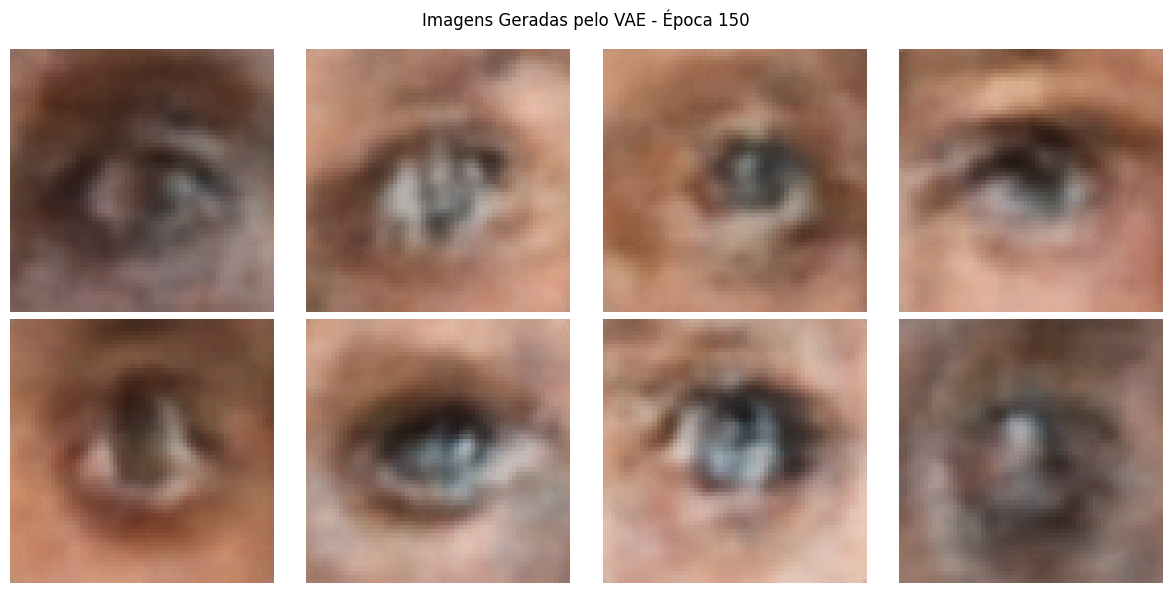

--- Treinamento do VAE Concluído ---


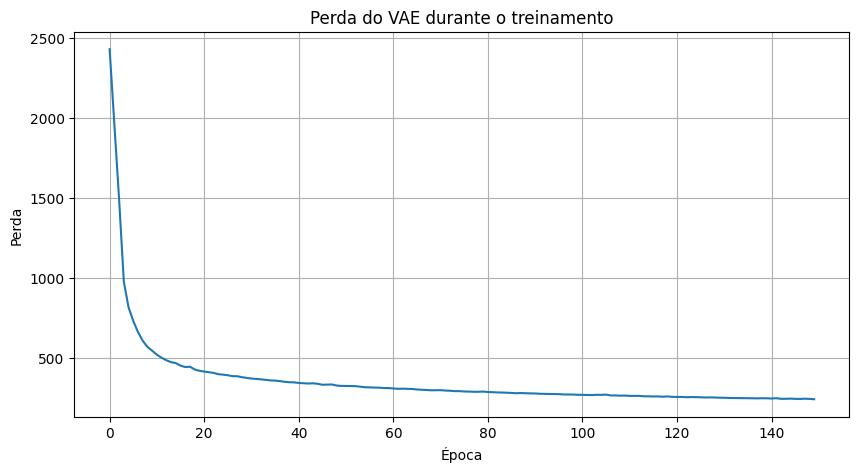

In [5]:
print("--- Iniciando Treinamento do VAE (150 Épocas) ---")

historico_perdas_vae = []

for epoca in range(epocas): # 150
    vae.train()
    perda_total_epoca = 0
    
    # Loop pelos lotes de imagens
    for batch_idx, imgs in enumerate(dataloader):
        imgs = imgs.to(device)
        optimizer_vae.zero_grad()
        imgs_reconstruidas, mu, logvar = vae(imgs)
        perda = calcular_perda_vae(imgs_reconstruidas, imgs, mu, logvar)
        perda.backward()
        optimizer_vae.step()
        perda_total_epoca += perda.item()
        
        # Mostrar progresso a cada 50 lotes
        if batch_idx % 50 == 0:
            perda_por_img = perda.item() / len(imgs)
            print(f"  Época {epoca+1}/{epocas} - Lote {batch_idx}/{len(dataloader)}, Perda por imagem: {perda_por_img:.4f}")
    
    perda_media_epoca = perda_total_epoca / len(dataset)
    historico_perdas_vae.append(perda_media_epoca)
    print(f"-> Fim da Época {epoca+1}/{epocas} - Perda média: {perda_media_epoca:.4f}")
    
    # Mostrar resultados a cada `mostrar_a_cada` épocas
    if (epoca + 1) % mostrar_a_cada == 0:
        print(f"--- Gerando imagens de exemplo da Época {epoca+1} ---")
        vae.eval()
        with torch.no_grad():
            ruido_teste = torch.randn(8, dim_latente).to(device)
            amostras_geradas = vae.decode(ruido_teste).cpu()
            
            plt.figure(figsize=(12, 6))
            for i in range(8):
                plt.subplot(2, 4, i+1)
                img = amostras_geradas[i].permute(1, 2, 0).numpy()
                img = (img + 1) / 2.0
                plt.imshow(img)
                plt.axis("off")
            plt.suptitle(f"Imagens Geradas pelo VAE - Época {epoca+1}")
            plt.tight_layout()
            plt.savefig(f"/content/resultados_olhos_150ep/vae_epoca_{epoca+1}.png")
            plt.show()

print("--- Treinamento do VAE Concluído ---")

# Plotar o gráfico de perda do VAE
plt.figure(figsize=(10, 5))
plt.plot(historico_perdas_vae)
plt.title('Perda do VAE durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.grid(True)
plt.savefig("/content/resultados_olhos_150ep/vae_perdas.png")
plt.show()

## Parte 2: GAN (Generative Adversarial Network)

- **Gerador**: Tenta criar imagens falsas que pareçam reais.
- **Discriminador**: Tenta descobrir quais imagens são reais e quais são falsas.

In [6]:
class Gerador(nn.Module):
    def __init__(self):
        super(Gerador, self).__init__()
        self.fc = nn.Linear(dim_latente, 128 * 8 * 8)
        self.bn1 = nn.BatchNorm1d(128 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 4, 2, 1)
    
    def forward(self, z):
        x = F.relu(self.bn1(self.fc(z)))
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.bn2(self.deconv1(x)))
        x = F.relu(self.bn3(self.deconv2(x)))
        x = torch.tanh(self.deconv3(x))
        return x

# Criar o Discriminador da GAN
class Discriminador(nn.Module):
    def __init__(self):
        super(Discriminador, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128 * 8 * 8, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn1(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv3(x)), 0.2)
        x = x.view(-1, 128 * 8 * 8)
        x = torch.sigmoid(self.fc(x))
        return x

gerador = Gerador().to(device)
discriminador = Discriminador().to(device)

# Otimizadores
optimizer_g = optim.Adam(gerador.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminador.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Função de perda
criterio_gan = nn.BCELoss()

--- Iniciando Treinamento da GAN (150 Épocas) ---
  Época 1/150 - Lote 0/44, Perda D: 1.4765, Perda G: 0.8957
-> Fim da Época 1/150 - Perda D média: 0.3042, Perda G média: 2.9915
  Época 2/150 - Lote 0/44, Perda D: 0.0636, Perda G: 4.4465
-> Fim da Época 2/150 - Perda D média: 0.0534, Perda G média: 5.1917
  Época 3/150 - Lote 0/44, Perda D: 0.0193, Perda G: 6.0112
-> Fim da Época 3/150 - Perda D média: 0.0207, Perda G média: 6.1845
  Época 4/150 - Lote 0/44, Perda D: 0.0217, Perda G: 6.1765
-> Fim da Época 4/150 - Perda D média: 0.0088, Perda G média: 6.6522
  Época 5/150 - Lote 0/44, Perda D: 0.0070, Perda G: 7.0049
-> Fim da Época 5/150 - Perda D média: 0.0074, Perda G média: 6.9177
  Época 6/150 - Lote 0/44, Perda D: 0.0265, Perda G: 9.0491
-> Fim da Época 6/150 - Perda D média: 0.1247, Perda G média: 7.6057
  Época 7/150 - Lote 0/44, Perda D: 0.2302, Perda G: 5.1240
-> Fim da Época 7/150 - Perda D média: 0.1904, Perda G média: 5.9795
  Época 8/150 - Lote 0/44, Perda D: 0.0634, Per

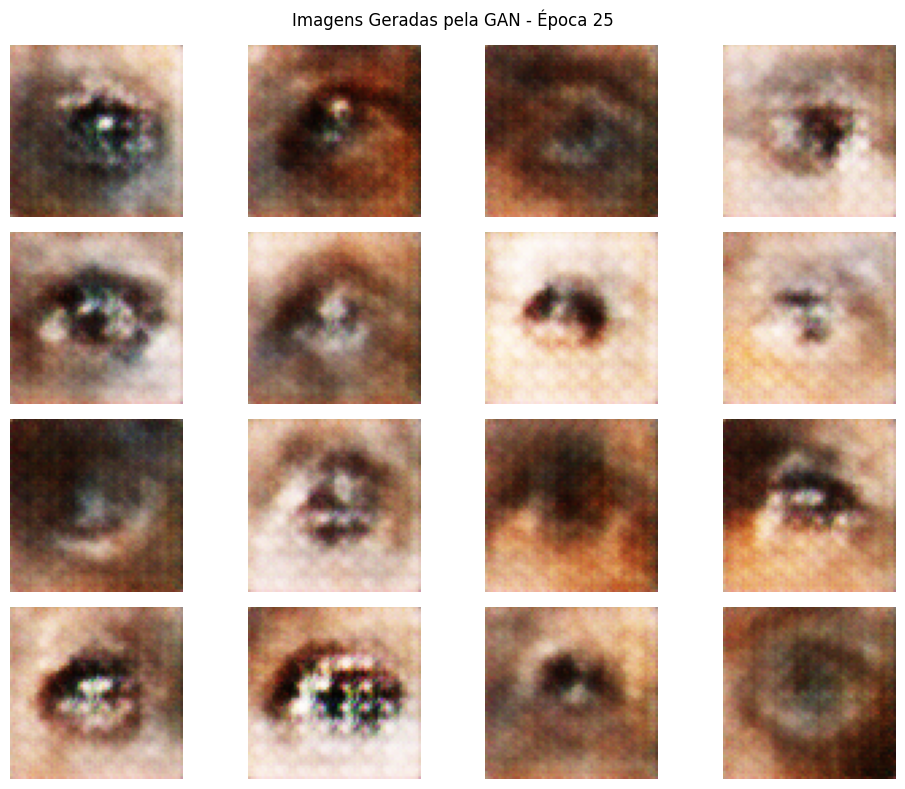

  Época 26/150 - Lote 0/44, Perda D: 0.3334, Perda G: 6.0250
-> Fim da Época 26/150 - Perda D média: 0.1624, Perda G média: 4.7758
  Época 27/150 - Lote 0/44, Perda D: 0.0358, Perda G: 5.5199
-> Fim da Época 27/150 - Perda D média: 0.0962, Perda G média: 4.8852
  Época 28/150 - Lote 0/44, Perda D: 0.0384, Perda G: 5.0619
-> Fim da Época 28/150 - Perda D média: 0.5782, Perda G média: 4.6115
  Época 29/150 - Lote 0/44, Perda D: 0.3240, Perda G: 5.7200
-> Fim da Época 29/150 - Perda D média: 0.1876, Perda G média: 4.1248
  Época 30/150 - Lote 0/44, Perda D: 0.1131, Perda G: 4.3835
-> Fim da Época 30/150 - Perda D média: 0.1477, Perda G média: 3.8399
  Época 31/150 - Lote 0/44, Perda D: 0.0900, Perda G: 4.1312
-> Fim da Época 31/150 - Perda D média: 0.1866, Perda G média: 3.8165
  Época 32/150 - Lote 0/44, Perda D: 0.1028, Perda G: 2.6410
-> Fim da Época 32/150 - Perda D média: 0.1922, Perda G média: 3.8641
  Época 33/150 - Lote 0/44, Perda D: 0.1692, Perda G: 4.0732
-> Fim da Época 33/150

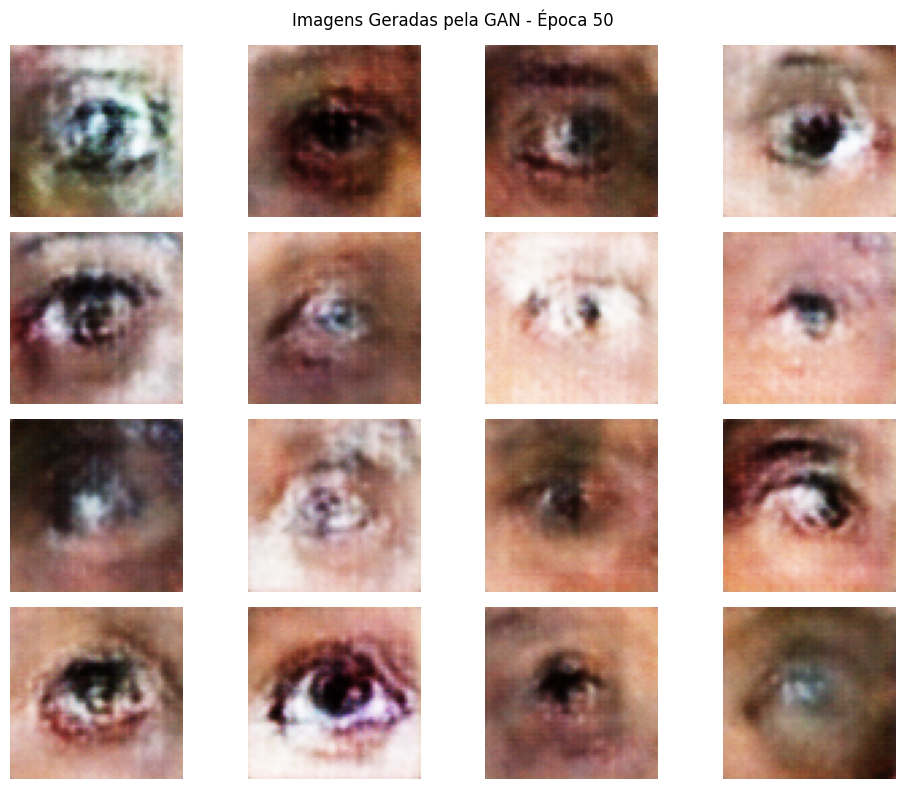

  Época 51/150 - Lote 0/44, Perda D: 0.3010, Perda G: 3.8665
-> Fim da Época 51/150 - Perda D média: 0.2280, Perda G média: 3.1579
  Época 52/150 - Lote 0/44, Perda D: 0.2848, Perda G: 2.7008
-> Fim da Época 52/150 - Perda D média: 0.1728, Perda G média: 3.1047
  Época 53/150 - Lote 0/44, Perda D: 0.3101, Perda G: 2.3101
-> Fim da Época 53/150 - Perda D média: 0.1287, Perda G média: 3.3703
  Época 54/150 - Lote 0/44, Perda D: 0.1150, Perda G: 3.6035
-> Fim da Época 54/150 - Perda D média: 0.1446, Perda G média: 3.4058
  Época 55/150 - Lote 0/44, Perda D: 0.1231, Perda G: 3.2778
-> Fim da Época 55/150 - Perda D média: 0.1657, Perda G média: 3.5244
  Época 56/150 - Lote 0/44, Perda D: 0.2169, Perda G: 2.7391
-> Fim da Época 56/150 - Perda D média: 0.7857, Perda G média: 3.4682
  Época 57/150 - Lote 0/44, Perda D: 1.5586, Perda G: 0.5555
-> Fim da Época 57/150 - Perda D média: 0.6573, Perda G média: 2.9768
  Época 58/150 - Lote 0/44, Perda D: 0.1138, Perda G: 4.3793
-> Fim da Época 58/150

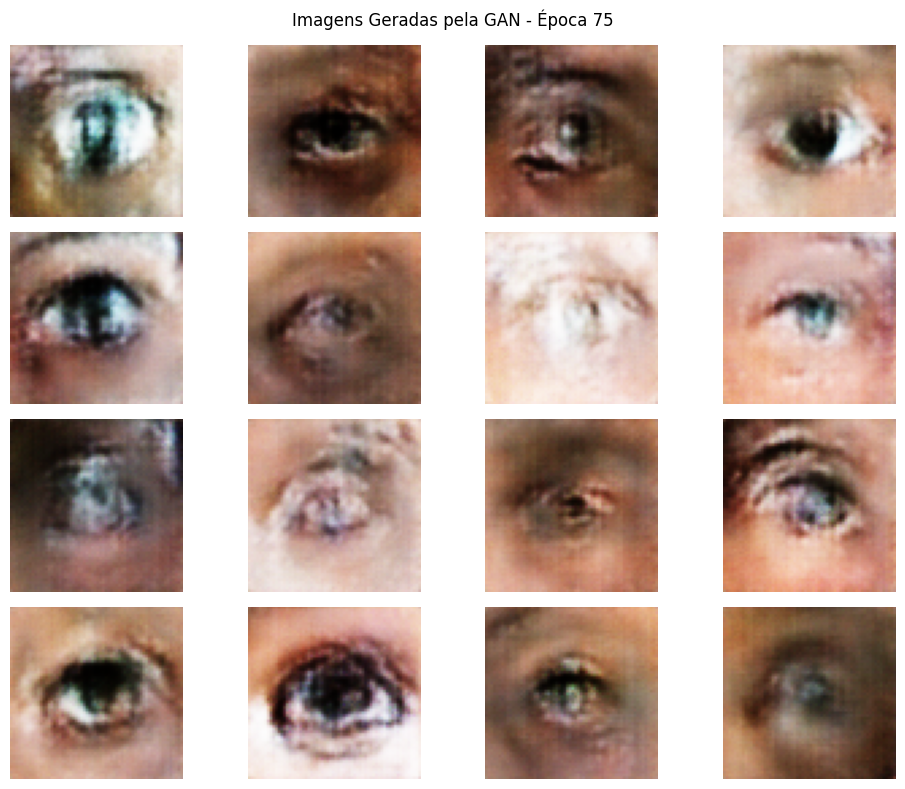

  Época 76/150 - Lote 0/44, Perda D: 0.1037, Perda G: 3.8811
-> Fim da Época 76/150 - Perda D média: 0.1213, Perda G média: 3.6725
  Época 77/150 - Lote 0/44, Perda D: 0.0634, Perda G: 5.4775
-> Fim da Época 77/150 - Perda D média: 0.1166, Perda G média: 3.7033
  Época 78/150 - Lote 0/44, Perda D: 0.1043, Perda G: 3.8584
-> Fim da Época 78/150 - Perda D média: 0.1362, Perda G média: 3.6794
  Época 79/150 - Lote 0/44, Perda D: 0.5912, Perda G: 0.7813
-> Fim da Época 79/150 - Perda D média: 0.9946, Perda G média: 3.0110
  Época 80/150 - Lote 0/44, Perda D: 0.3088, Perda G: 4.6004
-> Fim da Época 80/150 - Perda D média: 0.1857, Perda G média: 3.3972
  Época 81/150 - Lote 0/44, Perda D: 0.1304, Perda G: 3.7914
-> Fim da Época 81/150 - Perda D média: 0.1242, Perda G média: 3.5155
  Época 82/150 - Lote 0/44, Perda D: 0.1679, Perda G: 3.7169
-> Fim da Época 82/150 - Perda D média: 0.1254, Perda G média: 3.7050
  Época 83/150 - Lote 0/44, Perda D: 0.1448, Perda G: 3.6614
-> Fim da Época 83/150

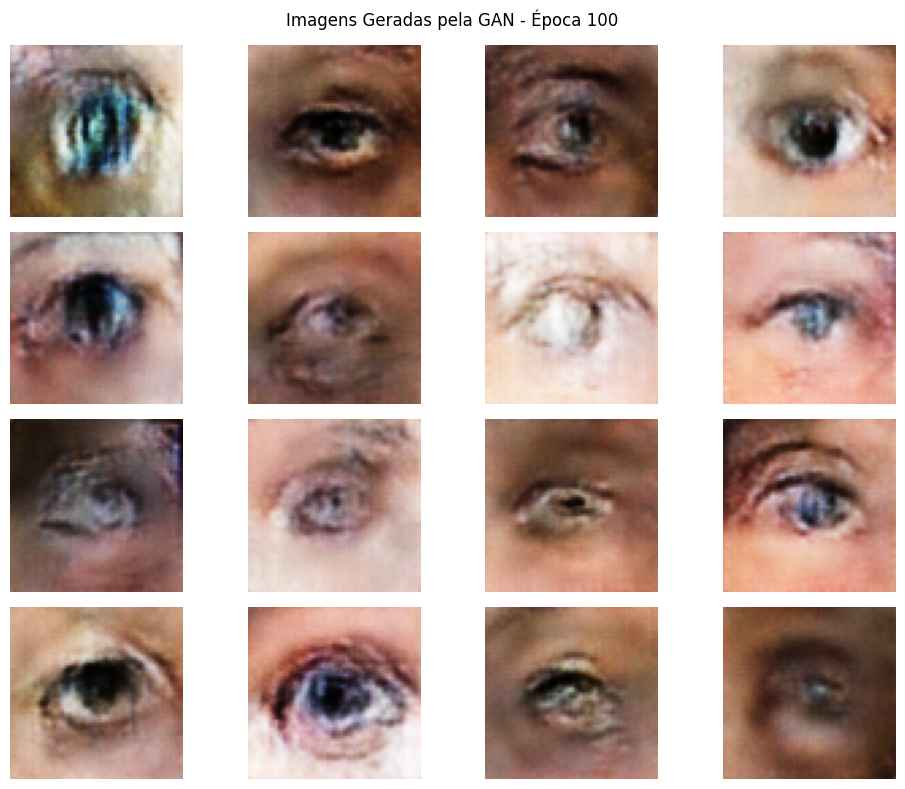

  Época 101/150 - Lote 0/44, Perda D: 0.1145, Perda G: 3.7990
-> Fim da Época 101/150 - Perda D média: 0.1164, Perda G média: 3.8334
  Época 102/150 - Lote 0/44, Perda D: 3.8421, Perda G: 11.4544
-> Fim da Época 102/150 - Perda D média: 1.1982, Perda G média: 3.5238
  Época 103/150 - Lote 0/44, Perda D: 1.6200, Perda G: 6.3452
-> Fim da Época 103/150 - Perda D média: 0.2465, Perda G média: 3.4894
  Época 104/150 - Lote 0/44, Perda D: 0.1216, Perda G: 4.1496
-> Fim da Época 104/150 - Perda D média: 0.1287, Perda G média: 3.5563
  Época 105/150 - Lote 0/44, Perda D: 0.1461, Perda G: 3.4958
-> Fim da Época 105/150 - Perda D média: 0.1098, Perda G média: 3.6825
  Época 106/150 - Lote 0/44, Perda D: 0.1518, Perda G: 3.9675
-> Fim da Época 106/150 - Perda D média: 0.1063, Perda G média: 3.7901
  Época 107/150 - Lote 0/44, Perda D: 0.2469, Perda G: 5.1353
-> Fim da Época 107/150 - Perda D média: 0.1175, Perda G média: 3.9054
  Época 108/150 - Lote 0/44, Perda D: 0.4370, Perda G: 5.6851
-> Fim

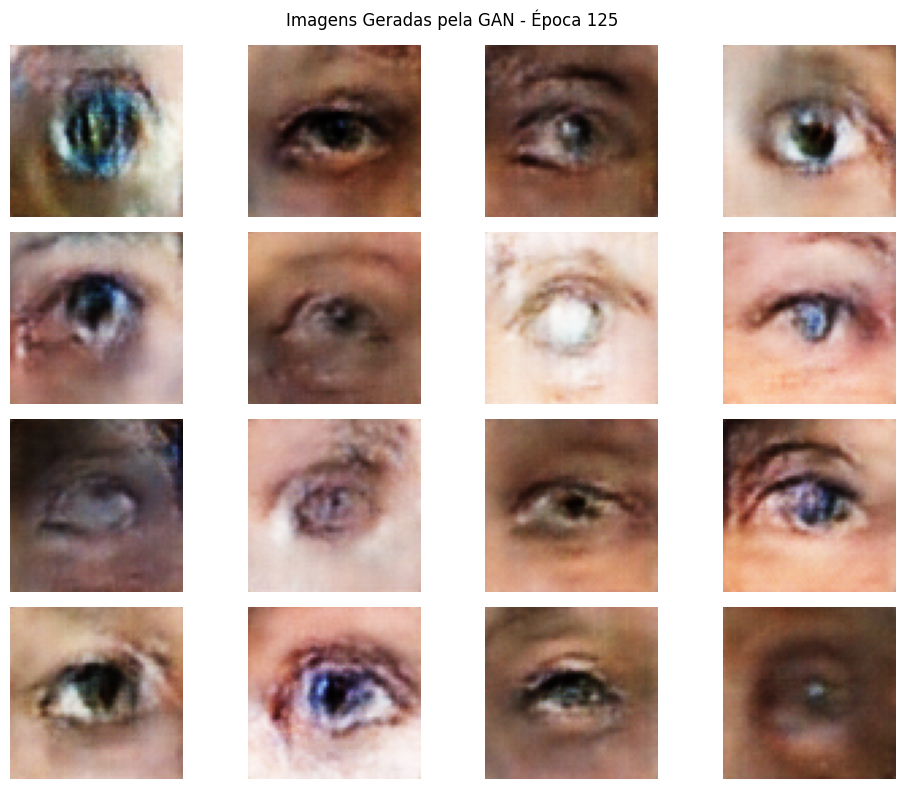

  Época 126/150 - Lote 0/44, Perda D: 0.1104, Perda G: 3.8899
-> Fim da Época 126/150 - Perda D média: 0.1101, Perda G média: 3.9404
  Época 127/150 - Lote 0/44, Perda D: 0.1651, Perda G: 5.1343
-> Fim da Época 127/150 - Perda D média: 0.5320, Perda G média: 3.9944
  Época 128/150 - Lote 0/44, Perda D: 0.1177, Perda G: 3.8304
-> Fim da Época 128/150 - Perda D média: 0.1201, Perda G média: 3.7784
  Época 129/150 - Lote 0/44, Perda D: 0.1763, Perda G: 3.5616
-> Fim da Época 129/150 - Perda D média: 0.1034, Perda G média: 3.9835
  Época 130/150 - Lote 0/44, Perda D: 0.1091, Perda G: 4.2775
-> Fim da Época 130/150 - Perda D média: 0.0970, Perda G média: 3.9705
  Época 131/150 - Lote 0/44, Perda D: 0.1170, Perda G: 4.1675
-> Fim da Época 131/150 - Perda D média: 0.1085, Perda G média: 3.9436
  Época 132/150 - Lote 0/44, Perda D: 0.1733, Perda G: 4.6934
-> Fim da Época 132/150 - Perda D média: 0.0991, Perda G média: 3.9960
  Época 133/150 - Lote 0/44, Perda D: 0.1617, Perda G: 4.3208
-> Fim 

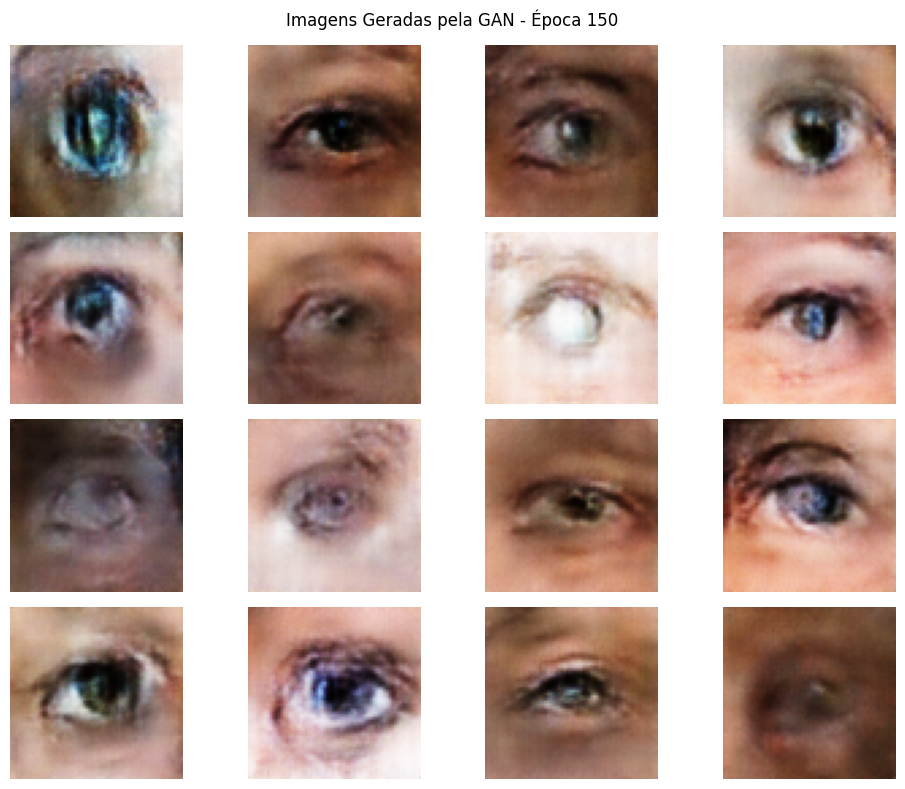

--- Treinamento da GAN Concluído ---


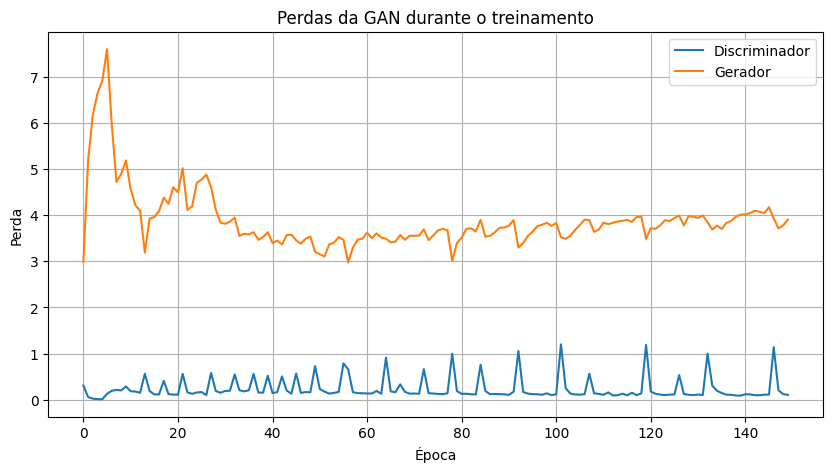

In [7]:
print("--- Iniciando Treinamento da GAN (150 Épocas) ---")

ruido_fixo_gan = torch.randn(16, dim_latente).to(device)

# Listas para guardar as perdas
historico_perdas_d = []
historico_perdas_g = []

for epoca in range(epocas): # 150
    perda_d_total = 0
    perda_g_total = 0
    
    # Loop pelos lotes
    for batch_idx, imgs_reais in enumerate(dataloader):
        batch_atual = imgs_reais.size(0)
        imgs_reais = imgs_reais.to(device)
        label_real = torch.ones(batch_atual).to(device)
        label_fake = torch.zeros(batch_atual).to(device)
        
        # --- Treinar Discriminador ---
        optimizer_d.zero_grad()
        # Reais
        saida_real = discriminador(imgs_reais).view(-1)
        perda_d_real = criterio_gan(saida_real, label_real)
        # Falsas
        ruido = torch.randn(batch_atual, dim_latente).to(device)
        imgs_falsas = gerador(ruido)
        saida_fake = discriminador(imgs_falsas.detach()).view(-1)
        perda_d_fake = criterio_gan(saida_fake, label_fake)
        # Total D
        perda_d = perda_d_real + perda_d_fake
        perda_d.backward()
        optimizer_d.step()
        perda_d_total += perda_d.item()
        
        # --- Treinar Gerador ---
        optimizer_g.zero_grad()
        # Tentar enganar
        saida_fake_pro_gerador = discriminador(imgs_falsas).view(-1)
        perda_g = criterio_gan(saida_fake_pro_gerador, label_real)
        # Atualizar G
        perda_g.backward()
        optimizer_g.step()
        perda_g_total += perda_g.item()
        
        # Mostrar progresso a cada 50 lotes
        if batch_idx % 50 == 0:
            print(f"  Época {epoca+1}/{epocas} - Lote {batch_idx}/{len(dataloader)}, Perda D: {perda_d.item():.4f}, Perda G: {perda_g.item():.4f}")
    
    # Calcular médias das perdas
    perda_d_media = perda_d_total / len(dataloader)
    perda_g_media = perda_g_total / len(dataloader)
    historico_perdas_d.append(perda_d_media)
    historico_perdas_g.append(perda_g_media)
    print(f"-> Fim da Época {epoca+1}/{epocas} - Perda D média: {perda_d_media:.4f}, Perda G média: {perda_g_media:.4f}")
            
    # Mostrar resultados a cada `mostrar_a_cada` épocas
    if (epoca + 1) % mostrar_a_cada == 0:
        print(f"--- Gerando imagens de exemplo da Época {epoca+1} ---")
        gerador.eval()
        with torch.no_grad():
            imgs_falsas_exemplo = gerador(ruido_fixo_gan).cpu()
            
            plt.figure(figsize=(10, 8))
            for i in range(16):
                plt.subplot(4, 4, i+1)
                img = imgs_falsas_exemplo[i].permute(1, 2, 0).numpy()
                img = (img + 1) / 2.0
                plt.imshow(img)
                plt.axis("off")
            plt.suptitle(f"Imagens Geradas pela GAN - Época {epoca+1}")
            plt.tight_layout()
            plt.savefig(f"/content/resultados_olhos_150ep/gan_epoca_{epoca+1}.png")
            plt.show()
        gerador.train()

print("--- Treinamento da GAN Concluído ---")

# Plotar o gráfico de perdas da GAN
plt.figure(figsize=(10, 5))
plt.plot(historico_perdas_d, label='Discriminador')
plt.plot(historico_perdas_g, label='Gerador')
plt.title('Perdas da GAN durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.savefig("/content/resultados_olhos_150ep/gan_perdas.png")
plt.show()

## Comparação dos Resultados Finais

imagens geradas pelo VAE e pela GAN lado a lado após 150 épocas.

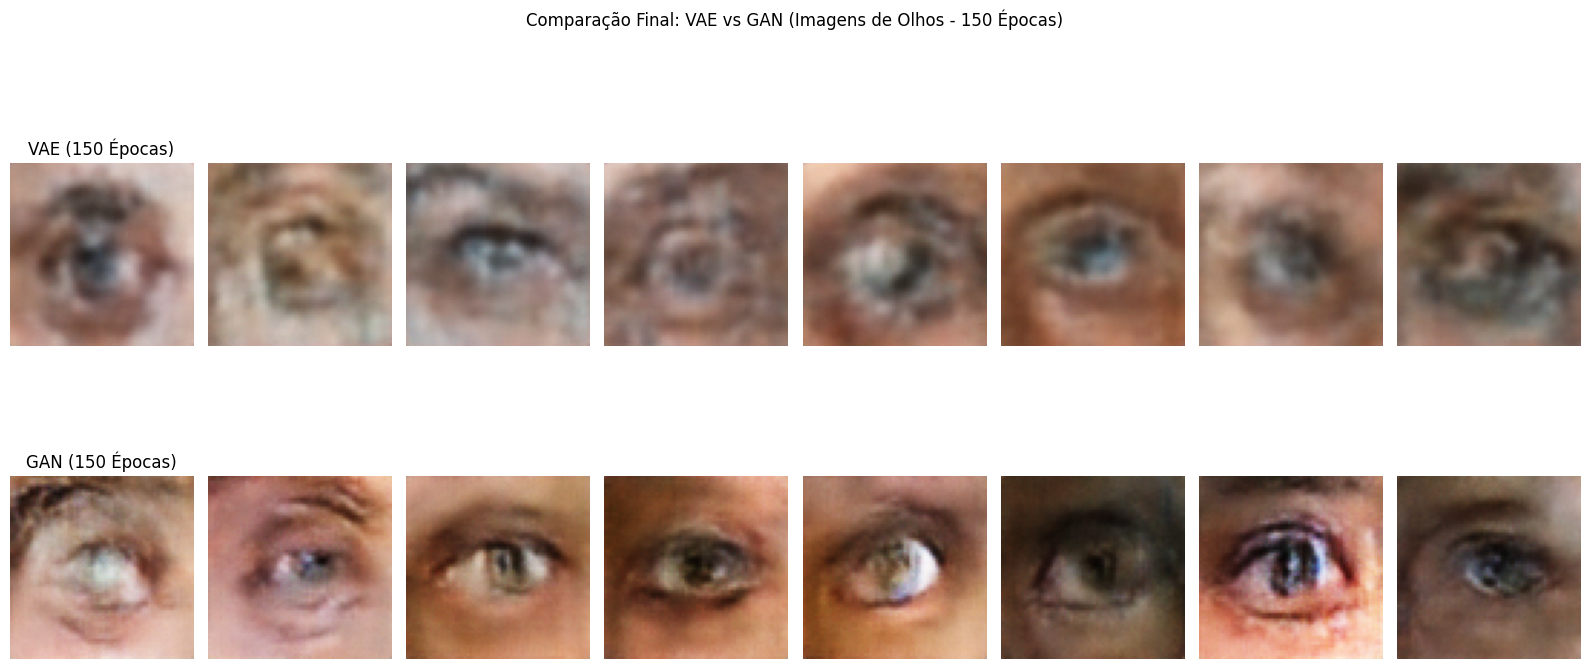

In [8]:
# Comparar os resultados finais
vae.eval()
gerador.eval()

with torch.no_grad():
    ruido_comparacao_vae = torch.randn(8, dim_latente).to(device)
    imgs_vae = vae.decode(ruido_comparacao_vae).cpu()
    ruido_comparacao_gan = torch.randn(8, dim_latente).to(device)
    imgs_gan = gerador(ruido_comparacao_gan).cpu()
    
    plt.figure(figsize=(16, 8))
    # VAE
    for i in range(8):
        plt.subplot(2, 8, i+1)
        img = imgs_vae[i].permute(1, 2, 0).numpy()
        img = (img + 1) / 2.0
        plt.imshow(img)
        if i == 0: plt.title("VAE (150 Épocas)")
        plt.axis("off")
    # GAN
    for i in range(8):
        plt.subplot(2, 8, i+9)
        img = imgs_gan[i].permute(1, 2, 0).numpy()
        img = (img + 1) / 2.0
        plt.imshow(img)
        if i == 0: plt.title("GAN (150 Épocas)")
        plt.axis("off")
    
    plt.suptitle("Comparação Final: VAE vs GAN (Imagens de Olhos - 150 Épocas)")
    plt.tight_layout()
    plt.savefig("/content/resultados_olhos_150ep/comparacao_final_olhos_150ep.png")
    plt.show()

## Verificando a Capacidade do Discriminador

Testando se o discriminador realmente consegue diferenciar entre imagens reais e falsas.

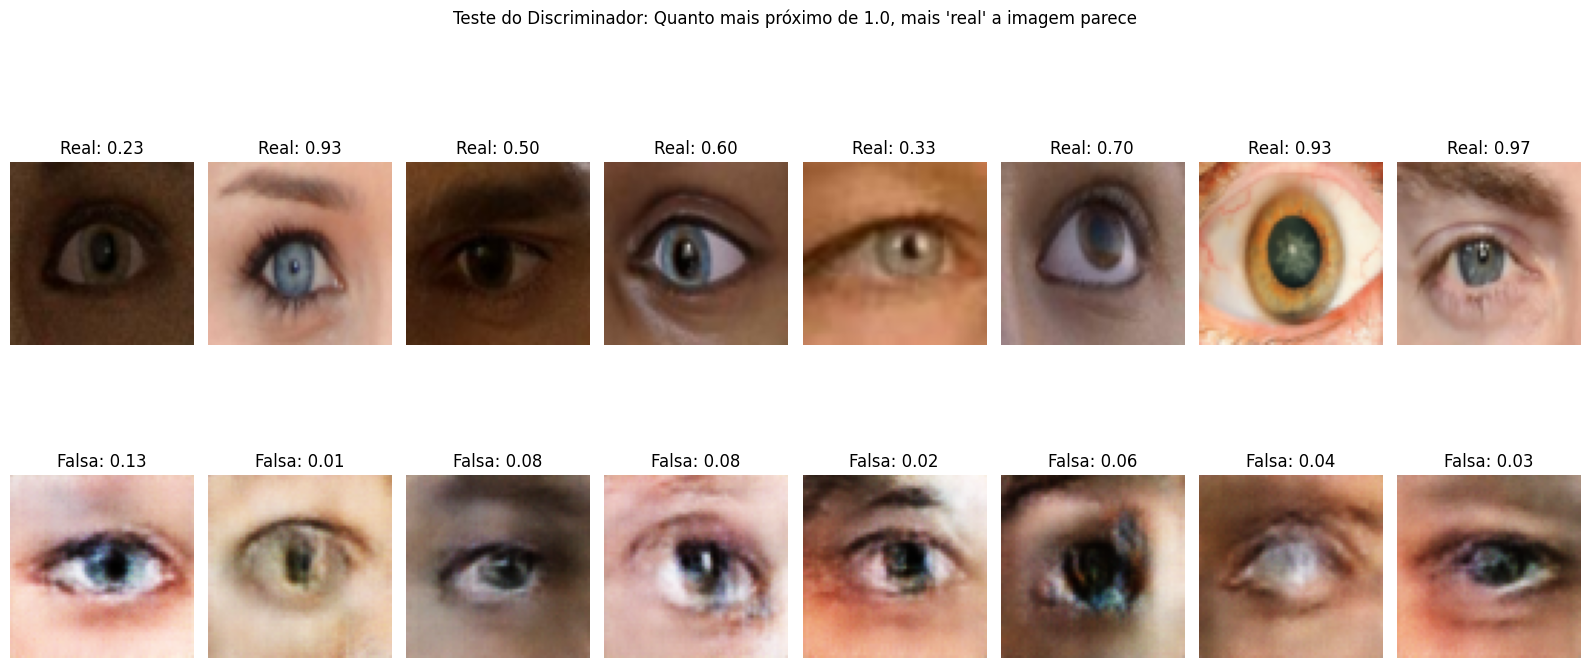

Pontuação média para imagens REAIS: 0.6486
Pontuação média para imagens FALSAS: 0.0558
Diferença média: 0.5927


In [9]:
# Testar o discriminador com imagens reais e falsas
discriminador.eval()

with torch.no_grad():
    # Pegar algumas imagens reais
    imgs_reais = next(iter(dataloader))[:8].to(device)
    
    # Gerar algumas imagens falsas
    ruido = torch.randn(8, dim_latente).to(device)
    imgs_falsas = gerador(ruido)
    
    # Passar pelo discriminador
    pontuacao_reais = discriminador(imgs_reais).cpu().numpy().flatten()
    pontuacao_falsas = discriminador(imgs_falsas).cpu().numpy().flatten()
    
    # Mostrar as imagens reais e suas pontuações
    plt.figure(figsize=(16, 8))
    plt.suptitle("Teste do Discriminador: Quanto mais próximo de 1.0, mais 'real' a imagem parece")
    
    # Imagens reais
    for i in range(8):
        plt.subplot(2, 8, i+1)
        img = imgs_reais[i].cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2.0
        plt.imshow(img)
        plt.title(f"Real: {pontuacao_reais[i]:.2f}")
        plt.axis("off")
    
    # Imagens falsas
    for i in range(8):
        plt.subplot(2, 8, i+9)
        img = imgs_falsas[i].cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2.0
        plt.imshow(img)
        plt.title(f"Falsa: {pontuacao_falsas[i]:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("/content/resultados_olhos_150ep/teste_discriminador.png")
    plt.show()
    
    # Mostrar estatísticas
    print(f"Pontuação média para imagens REAIS: {pontuacao_reais.mean():.4f}")
    print(f"Pontuação média para imagens FALSAS: {pontuacao_falsas.mean():.4f}")
    print(f"Diferença média: {pontuacao_reais.mean() - pontuacao_falsas.mean():.4f}")